# Cross Refering LiDAR

## With open street maps buildings

In [6]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from rasterstats import zonal_stats
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm

# --- Parameters ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "paris_buildings_large_merged.gpkg"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar_osm.tif"
invalid_height_value = -9999


In [7]:
# --- UTIL: Fill missing data using nearest valid neighbor ---
def fill_nearest(data, nodata=np.nan):
    mask = np.isnan(data) if np.isnan(nodata) else (data == nodata)
    inds = distance_transform_edt(mask, return_distances=False, return_indices=True)
    return data[tuple(inds)]

# --- STEP 1: Merge tiles ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith(".tif")]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans, "dtype": "float32"})
    for src in srcs:
        src.close()
    return mosaic[0].astype(np.float32), meta

print("Merging and filling roof and ground rasters...")
roof_raw, meta = merge_tiles(roof_dir, "_roofs")
ground_raw, meta2 = merge_tiles(ground_dir, "_ground")

roof_filled = fill_nearest(np.where(roof_raw == invalid_height_value, np.nan, roof_raw))
ground_filled = fill_nearest(np.where(ground_raw == invalid_height_value, np.nan, ground_raw))

Merging and filling roof and ground rasters...


In [8]:
# --- STEP 2: Resample ground to roof grid ---
print("Resampling ground to match roof resolution...")
resampled_ground = np.full_like(roof_filled, invalid_height_value, dtype=np.float32)

reproject(
    source=ground_filled,
    destination=resampled_ground,
    src_transform=meta2["transform"],
    src_crs=meta2["crs"],
    dst_transform=meta["transform"],
    dst_crs=meta["crs"],
    resampling=Resampling.nearest,
    src_nodata=invalid_height_value,
    dst_nodata=invalid_height_value
)


Resampling ground to match roof resolution...


(array([[ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        [ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        [ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        ...,
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315],
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315],
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315]], shape=(3201, 4201), dtype=float32),
 Affine(5.0, 0.0, 641000.0,
        0.0, -5.0, 6870005.0))

In [9]:
# --- STEP 3: Compute height raster ---
print("Computing height raster...")
height_raster = roof_filled - resampled_ground
height_raster[roof_filled == 0] = np.nan

Computing height raster...


In [ ]:
#--- STEP 4: Assign height to buildings ---
print("Assigning heights to building footprints...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])

In [13]:
zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
buildings["height"] = [z["mean"] if z["mean"] is not None else invalid_height_value for z in zs]
valid_buildings = buildings[buildings["height"] != invalid_height_value].copy()

In [15]:
# --- Step 4: Load global raster and crop to AOI ---
print("Cropping global raster to area of interest...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    # Reproject buildings to global raster CRS
    valid_buildings = valid_buildings.to_crs(global_crs)

    # Get bounding box of valid buildings and crop raster
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]



Cropping global raster to area of interest...


In [16]:
# --- Step 5: Calculate lambda_b per grid cell in AOI ---
print("Calculating lambda_b values...")
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
cell_area = res_x * res_y
updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

Calculating lambda_b values...


In [27]:
from shapely.geometry import Polygon

print("Vectorizing grid and calculating lambda_b...")

# Step 5a: Generate grid as GeoDataFrame
grid_polys = []
rows, cols = updated.shape
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))


# Keep grid in its original CRS from global raster
grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs  # do NOT change this
)

# Auto-detect projected CRS for accurate area/length calculations
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    epsg_code = 32600 + zone_number if lat >= 0 else 32700 + zone_number
    return f"EPSG:{epsg_code}"

# 2nd try
def get_utm_crs(geo_df):
    centroid = geo_df.geometry.unary_union.centroid  # Avoids deprecated .unary_union.centroid
    lon, lat = centroid.x, centroid.y

    # Clamp longitude and latitude to avoid invalid zones
    if np.isnan(lon) or np.isnan(lat):
        raise ValueError("Invalid centroid coordinates")

    zone_number = max(1, min(60, int((lon + 180) / 6)))
    return f"EPSG:{32600 + zone_number}" if lat >= 0 else f"EPSG:{32700 + zone_number}"


# Reproject buildings to projected CRS for area calculations
projected_crs = get_utm_crs(grid_gdf)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_proj = grid_gdf.to_crs(projected_crs)




Vectorizing grid and calculating lambda_b...


/var/folders/mm/04w0hy711n93_t1jwlzttfg00000gp/T/ipykernel_49987/3322706448.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = geo_df.geometry.unary_union.centroid  # Avoids deprecated .unary_union.centroid


In [ ]:
# old way probably deprecated
# Intersect in projected space (clipped shapes per grid cell)
intersection = gpd.overlay(valid_buildings_proj, grid_proj, how="intersection")

cell_area = 6596.8

# Compute roof + wall areas (in meters²)
intersection["roof_area"] = intersection.geometry.area
intersection["perimeter"] = intersection.geometry.length
intersection["wall_area"] = intersection["perimeter"] * intersection["height"]
intersection["lambda_b"] = (intersection["wall_area"] + intersection["roof_area"]) / cell_area

# Group by original row/col
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# 🔁 Write values back to your unchanged grid array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

In [47]:
## Fixed way counting wall substraction
# Intersect buildings with grid (still in projected CRS)
intersection = gpd.overlay(valid_buildings_proj, grid_proj, how="intersection")

# Rename and remerge grid_geom if needed
intersection = intersection.merge(
    grid_proj[["row", "col", "geometry"]].rename(columns={"geometry": "grid_geom"}),
    on=["row", "col"],
    how="left"
)

# Compute shared perimeter (fake walls from clipping)
intersection["shared_border"] = intersection.geometry.boundary.intersection(intersection["grid_geom"].boundary)
intersection["shared_len"] = intersection["shared_border"].length

# True perimeter = total minus shared (clip walls away!)
intersection["perimeter"] = intersection.geometry.length - intersection["shared_len"]

# Final λ_B calculation
cell_area = 6596.8
intersection["roof_area"] = intersection.geometry.area
intersection["wall_area"] = intersection["perimeter"] * intersection["height"]
intersection["lambda_b"] = (intersection["roof_area"] + intersection["wall_area"]) / cell_area

# Group per cell
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# Update raster
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]


Saving updated raster to lambda_b_updated_Paris_lidar_osm.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


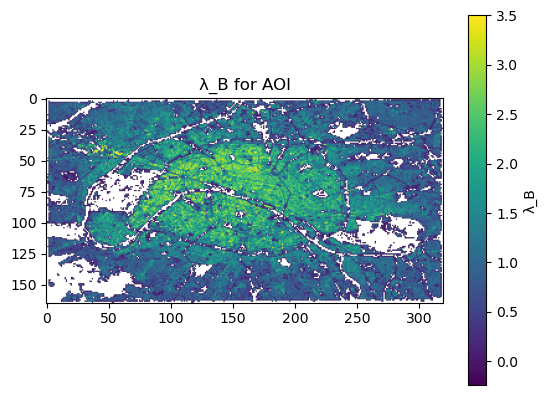

In [50]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open('lidar_osm_test2_fixedwallscount' + output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis',vmax=3.5)
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


Saving updated raster to lambda_b_updated_Paris_lidar_osm.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


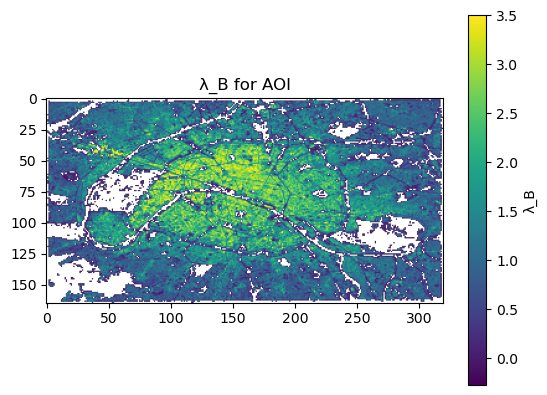

In [38]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open('lidar_osm_test1' + output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis',vmax=3.5)
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


In [45]:
valid_buildings

,geometry,height
0,"POLYGON ((2.19848 48.79462, 2.19857 48.79468, ...",6.508564
1,"POLYGON ((2.19834 48.79473, 2.19836 48.79475, ...",1.313232
2,"POLYGON ((2.19842 48.79479, 2.19846 48.79481, ...",6.191900
3,"POLYGON ((2.19782 48.79505, 2.19779 48.79507, ...",4.470198
4,"POLYGON ((2.19887 48.79472, 2.19878 48.79467, ...",6.237191
...,...,...
160756,"POLYGON ((2.48056 48.92764, 2.48054 48.92766, ...",5.052419
160758,"POLYGON ((2.48072 48.92783, 2.48079 48.92777, ...",4.719897
160759,"POLYGON ((2.48069 48.92795, 2.48062 48.92791, ...",0.264736
160760,"POLYGON ((2.48047 48.92814, 2.48056 48.92816, ...",2.611946


In [46]:
intersection.to_file("buildings_intersected.gpkg", driver="GPKG")

In [44]:
intersection#[['surface']].drop_duplicates()

,height,row,col,geometry,roof_area,perimeter,wall_area,lambda_b
0,6.508564,151,3,"POLYGON ((881727.892 5417677.089, 881730.967 5...",86.819974,39.490116,257.023945,0.052123
1,1.313232,150,3,"POLYGON ((881711.864 5417683.917, 881716.676 5...",17.496481,20.068007,26.353958,0.006647
2,1.313232,151,3,"POLYGON ((881714.881 5417677.538, 881710.488 5...",23.060129,21.793144,28.619463,0.007834
3,6.191900,150,3,"POLYGON ((881718.864 5417691.54, 881721.689 54...",115.327232,47.916398,296.693554,0.062458
4,6.191900,151,3,"POLYGON ((881729.934 5417679.573, 881725.614 5...",21.819543,22.532959,139.521836,0.024458
...,...,...,...,...,...,...,...,...
254613,5.052419,3,317,"POLYGON ((901356.727 5433905.947, 901355.048 5...",89.098299,68.154300,344.344099,0.065705
254614,4.719897,3,317,"POLYGON ((901374.713 5433919.454, 901370.755 5...",49.697171,28.969049,136.730925,0.028260
254615,0.264736,2,317,"POLYGON ((901360.712 5433934.578, 901357.692 5...",35.036168,24.030496,6.361742,0.006275
254616,2.611946,2,317,"POLYGON ((901354.605 5433961.318, 901358.907 5...",55.309061,31.101394,81.235165,0.020699


## With MFS Buildings

In [1]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.merge import merge
from rasterio.mask import mask
from shapely.geometry import box
from rasterstats import zonal_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# --- Parameters ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "/Users/gabeiras3j/01_year_2/01_Data/21_Microsoft_buildings/example_building_footprints_Paris.geojson"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar.tif"
invalid_height_value = -9999

# --- Step 1: Merge roof and ground rasters ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith('.tif')]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans})
    for src in srcs:
        src.close()
    return mosaic[0], meta

print("Merging roof and ground tiles...")
roof, meta = merge_tiles(roof_dir, "_roofs")
ground, _ = merge_tiles(ground_dir, "_ground")



Merging roof and ground tiles...


In [ ]:
# # --- Step 2: Compute height raster ---
# print("Calculating height raster...")
# height_raster = roof - ground
# height_raster[(roof == 0) | (ground == 0)] = np.nan  # filter invalids

In [2]:
# --- Step 3: Assign height to building footprints ---
print("Assigning heights to building footprints...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])  # ensure CRS match

Assigning heights to building footprints...


In [3]:
# zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
# buildings["height"] = [z["mean"] if z["mean"] is not None else invalid_height_value for z in zs]

In [4]:
# run this is need heights for testing
buildings['heightMS'] = [float(buildings['properties'][i][12:15]) for i in buildings.index]

In [5]:
# Filter buildings with valid heights
valid_buildings = buildings[buildings["heightMS"] != invalid_height_value].copy()

# --- Step 4: Load global raster and crop to AOI ---
print("Cropping global raster to area of interest...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    # Reproject buildings to global raster CRS
    valid_buildings = valid_buildings.to_crs(global_crs)

    # Get bounding box of valid buildings and crop raster
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]



Cropping global raster to area of interest...


In [8]:
# --- Step 5: Calculate lambda_b per grid cell in AOI ---
print("Calculating lambda_b values...")
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
cell_area = res_x * res_y
updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

Calculating lambda_b values...


In [9]:
from shapely.geometry import Polygon

print("Vectorizing grid and calculating lambda_b...")

# Step 5a: Generate grid as GeoDataFrame
grid_polys = []
rows, cols = updated.shape
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))


# Keep grid in its original CRS from global raster
grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs  # do NOT change this
)

# Auto-detect projected CRS for accurate area/length calculations
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    epsg_code = 32600 + zone_number if lat >= 0 else 32700 + zone_number
    return f"EPSG:{epsg_code}"

# Reproject buildings to projected CRS for area calculations
projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_proj = grid_gdf.to_crs(projected_crs)

# Intersect in projected space (clipped shapes per grid cell)
intersection = gpd.overlay(valid_buildings_proj, grid_proj, how="intersection")


Vectorizing grid and calculating lambda_b...


/var/folders/mm/04w0hy711n93_t1jwlzttfg00000gp/T/ipykernel_28278/2455272299.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = geo_df.unary_union.centroid


In [10]:
cell_area = 6596.8

In [11]:
# Compute roof + wall areas (in meters²)
intersection["roof_area"] = intersection.geometry.area
intersection["perimeter"] = intersection.geometry.length
intersection["wall_area"] = intersection["perimeter"] * intersection["heightMS"]
intersection["lambda_b"] = (intersection["wall_area"] + intersection["roof_area"]) / cell_area

# Group by original row/col
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# 🔁 Write values back to your unchanged grid array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


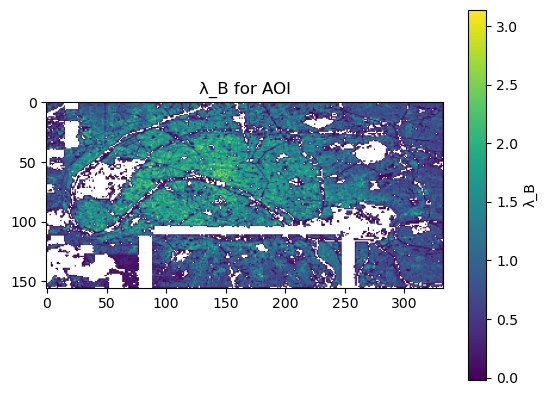

In [12]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


## With lidar heights

In [17]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from rasterstats import zonal_stats
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm

# --- UTIL: Fill missing data using nearest valid neighbor ---
def fill_nearest(data, nodata=np.nan):
    mask = np.isnan(data) if np.isnan(nodata) else (data == nodata)
    inds = distance_transform_edt(mask, return_distances=False, return_indices=True)
    return data[tuple(inds)]

# --- STEP 1: Merge tiles ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith(".tif")]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans, "dtype": "float32"})
    for src in srcs:
        src.close()
    return mosaic[0].astype(np.float32), meta

print("Merging and filling roof and ground rasters...")
roof_raw, meta = merge_tiles(roof_dir, "_roofs")
ground_raw, meta2 = merge_tiles(ground_dir, "_ground")

roof_filled = fill_nearest(np.where(roof_raw == invalid_height_value, np.nan, roof_raw))
ground_filled = fill_nearest(np.where(ground_raw == invalid_height_value, np.nan, ground_raw))

Merging and filling roof and ground rasters...


In [18]:
# --- STEP 2: Resample ground to roof grid ---
print("Resampling ground to match roof resolution...")
resampled_ground = np.full_like(roof_filled, invalid_height_value, dtype=np.float32)

reproject(
    source=ground_filled,
    destination=resampled_ground,
    src_transform=meta2["transform"],
    src_crs=meta2["crs"],
    dst_transform=meta["transform"],
    dst_crs=meta["crs"],
    resampling=Resampling.nearest,
    src_nodata=invalid_height_value,
    dst_nodata=invalid_height_value
)


Resampling ground to match roof resolution...


(array([[ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        [ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        [ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        ...,
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315],
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315],
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315]], shape=(3201, 4201), dtype=float32),
 Affine(5.0, 0.0, 641000.0,
        0.0, -5.0, 6870005.0))

In [19]:
# --- STEP 3: Compute height raster ---
print("Computing height raster...")
height_raster = roof_filled - resampled_ground
height_raster[roof_filled == 0] = np.nan

Computing height raster...


In [20]:
# --- STEP 4: Assign height to buildings ---
# print("Assigning heights to building footprints...")
# buildings = gpd.read_file(building_fp)
# buildings = buildings.to_crs(meta["crs"])

zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
buildings["height"] = [z["mean"] if z["mean"] is not None else invalid_height_value for z in zs]
valid_buildings = buildings[buildings["heightMS"] != invalid_height_value].copy()

In [22]:
# --- Step 5: Calculate lambda_b per grid cell in AOI ---
print("Calculating lambda_b values...")
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
cell_area = res_x * res_y
updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

Calculating lambda_b values...


In [35]:
valid_buildings['geometry'] = valid_buildings.buffer(0)

In [39]:
valid_buildings

,type,properties,id,geometry,heightMS,height
0,Feature,"{ ""height"": 6.3150730133056641, ""confidence"": ...",0,"POLYGON ((641734.885 6866530.029, 641722.287 6...",6.3,5.898723
1,Feature,"{ ""height"": -1.0, ""confidence"": 0.969200015068...",1,"POLYGON ((641770.303 6869115.895, 641766.201 6...",-1.0,5.995650
2,Feature,"{ ""height"": 3.430219173431396, ""confidence"": -...",2,"POLYGON ((641760.31 6863326.344, 641743.208 68...",3.4,5.206525
3,Feature,"{ ""height"": -1.0, ""confidence"": 0.997500002384...",3,"POLYGON ((641815.856 6868509.647, 641813.291 6...",-1.0,12.302032
4,Feature,"{ ""height"": 3.8227400779724121, ""confidence"": ...",4,"POLYGON ((641785.226 6863312.528, 641779.747 6...",3.8,4.424173
...,...,...,...,...,...,...
167704,Feature,"{ ""height"": 12.402072906494141, ""confidence"": ...",167704,"POLYGON ((661961.373 6855142.904, 661980.509 6...",12.0,12.501562
167705,Feature,"{ ""height"": 4.6434597969055176, ""confidence"": ...",167705,"POLYGON ((661988.049 6857654.563, 661989.467 6...",4.6,7.006245
167706,Feature,"{ ""height"": 5.213249683380127, ""confidence"": -...",167706,"POLYGON ((661978.631 6855538.512, 661964.066 6...",5.2,8.006695
167707,Feature,"{ ""height"": 4.6503071784973145, ""confidence"": ...",167707,"POLYGON ((661978.17 6854893.576, 661978.152 68...",4.6,5.616539


In [40]:
from shapely.geometry import Polygon

print("Vectorizing grid and calculating lambda_b...")

# Step 5a: Generate grid as GeoDataFrame
grid_polys = []
rows, cols = updated.shape
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))


# Keep grid in its original CRS from global raster
grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs  # do NOT change this
)

# Auto-detect projected CRS for accurate area/length calculations
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    epsg_code = 32600 + zone_number if lat >= 0 else 32700 + zone_number
    return f"EPSG:{epsg_code}"

# 2nd try
def get_utm_crs(geo_df):
    centroid = geo_df.geometry.unary_union.centroid  # Avoids deprecated .unary_union.centroid
    lon, lat = centroid.x, centroid.y

    # Clamp longitude and latitude to avoid invalid zones
    if np.isnan(lon) or np.isnan(lat):
        raise ValueError("Invalid centroid coordinates")

    zone_number = max(1, min(60, int((lon + 180) / 6)))
    return f"EPSG:{32600 + zone_number}" if lat >= 0 else f"EPSG:{32700 + zone_number}"


# Reproject buildings to projected CRS for area calculations
projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_proj = grid_gdf.to_crs(projected_crs)

# Intersect in projected space (clipped shapes per grid cell)
intersection = gpd.overlay(valid_buildings_proj, grid_proj, how="intersection")


Vectorizing grid and calculating lambda_b...


/var/folders/mm/04w0hy711n93_t1jwlzttfg00000gp/T/ipykernel_28278/2061388627.py:33: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = geo_df.geometry.unary_union.centroid  # Avoids deprecated .unary_union.centroid


In [43]:
cell_area = 6596.8

In [46]:
# Compute roof + wall areas (in meters²)
intersection["roof_area"] = intersection.geometry.area
intersection["perimeter"] = intersection.geometry.length
intersection["wall_area"] = intersection["perimeter"] * intersection["height"]
intersection["lambda_b"] = (intersection["wall_area"] + intersection["roof_area"]) / cell_area

# Group by original row/col
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# 🔁 Write values back to your unchanged grid array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


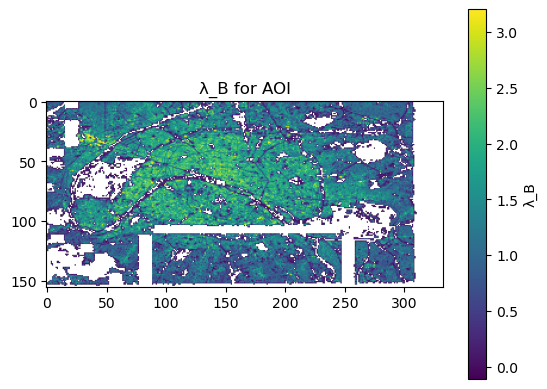

In [48]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open(output_raster_path + 'lidartest1', "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis',vmax=3.2)
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


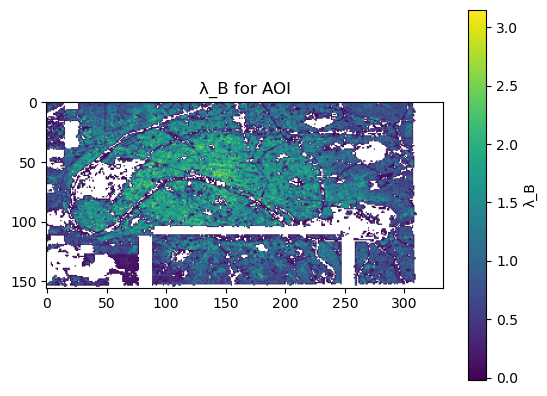

In [45]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")
with rasterio.open(output_raster_path + 'lidartest1', "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()
